In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
# 1. Load SMS Spam Dataset
def load_sms_spam_dataset(filepath):
    data = pd.read_csv(filepath, sep='\t', names=['label', 'text'], header=None)
    data['label'] = data['label'].map({'ham': 0, 'spam': 1})
    return data

In [11]:
# 2. Preprocess Text
def preprocess_text(df, max_words=5000, max_len=100):
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(df['text'])

    sequences = tokenizer.texts_to_sequences(df['text'])
    X = pad_sequences(sequences, maxlen=max_len)
    y = df['label'].values

    print("\nPreprocessing Info:")
    print(f"Vocabulary size: {len(tokenizer.word_index) + 1}")
    print(f"Sequence length: {max_len}")
    print(f"Total samples: {len(X)}")

    return X, y, tokenizer

In [20]:
# 3. Build RNN Model
def build_rnn_model(vocab_size, max_len):
    inputs = tf.keras.Input(shape=(max_len,))
    x = tf.keras.layers.Embedding(vocab_size, 128)(inputs)
    x = tf.keras.layers.SimpleRNN(64, return_sequences=True)(x)
    x = tf.keras.layers.SimpleRNN(32)(x)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print(model.summary())
    return model

In [13]:
# 4. Train Model with EarlyStopping
def train_model(model, X_train, y_train):
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping]
    )
    return history


In [6]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [15]:
# 6. Evaluate Model
def evaluate_model(model, X_test, y_test):
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"\nTest Accuracy: {accuracy:.4f}")


In [16]:
# 7. Predict Sentiment (Spam or Ham)
def predict_sentiment(model, tokenizer, text, max_len):
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_len)
    prediction = model.predict(padded)[0][0]
    sentiment = 'Spam' if prediction > 0.5 else 'Ham'
    confidence = float(prediction if prediction > 0.5 else 1 - prediction)
    return {
        'text': text,
        'prediction': sentiment,
        'confidence': round(confidence, 4)
    }


Preprocessing Info:
Vocabulary size: 9010
Sequence length: 100
Total samples: 5572


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 100, 128)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_4 (SimpleRNN)             │ (None, 100, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_5 (SimpleRNN)             │ (None, 32)                  │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 656,001 (2.50 MB)

 Trainable params: 656,001 (2.50 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.7341 - loss: 0.4543 - val_accuracy: 0.9697 - val_loss: 0.1053
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.9778 - loss: 0.1100 - val_accuracy: 0.9753 - val_loss: 0.0867
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.9958 - loss: 0.0395 - val_accuracy: 0.9753 - val_loss: 0.1094
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.9988 - loss: 0.0262 - val_accuracy: 0.9821 - val_loss: 0.0977
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9974 - loss: 0.0216 - val_accuracy: 0.9776 - val_loss: 0.1014


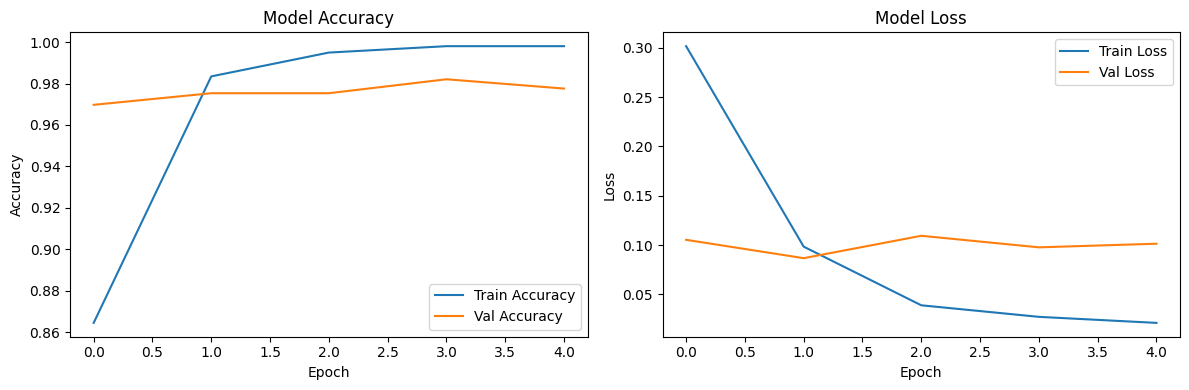

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9801 - loss: 0.0654

Test Accuracy: 0.9848
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step

Example Prediction:
{'text': "Congratulations! You've won a free prize. Call now!", 'prediction': 'Spam', 'confidence': 0.9743}


In [21]:
if __name__ == "__main__":
    # Filepath to SMS Spam Collection dataset
    filepath = r"C:\Users\HP\Downloads\sms+spam+collection\SMSSpamCollection"
    
    # Step 1: Load Dataset
    df = load_sms_spam_dataset(filepath)

    # Step 2: Preprocess
    max_words = 5000
    max_len = 100
    X, y, tokenizer = preprocess_text(df, max_words, max_len)

    # Step 3: Split into Train and Test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Step 4: Build and Train Model
    vocab_size = min(len(tokenizer.word_index) + 1, max_words)
    model = build_rnn_model(vocab_size, max_len)
    history = train_model(model, X_train, y_train)

    # Step 5: Visualize Training
    plot_training_history(history)

    # Step 6: Evaluate on Test Set
    evaluate_model(model, X_test, y_test)

    # Step 7: Make Example Prediction
    example = predict_sentiment(model, tokenizer, "Congratulations! You've won a free prize. Call now!", max_len)
    print("\nExample Prediction:")
    print(example)